In [2]:
import pymc3 as pm
import theano.tensor as tt
import theano.tensor.slinalg as sla
import theano.tensor.nlinalg as nla
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

/home/nilavro/irleak/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
disaster_data = np.ma.masked_values([4, 5, 4, 0, 1, 4, 3, 4, 0, 6, 3, 3, 4, 0, 2, 6,
3, 3, 5, 4, 5, 3, 1, 4, 4, 1, 5, 5, 3, 4, 2, 5,
2, 2, 3, 4, 2, 1, 3, -999, 2, 1, 1, 1, 1, 3, 0, 0,
1, 0, 1, 1, 0, 0, 3, 1, 0, 3, 2, 2, 0, 1, 1, 1,
0, 1, 0, 1, 0, 0, 0, 2, 1, 0, 0, 0, 1, 1, 0, 2,
3, 3, 1, -999, 2, 1, 1, 1, 1, 2, 4, 2, 0, 0, 1, 4,
0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1], value=-999)

In [4]:
year = np.arange(1851, 1962)


In [27]:
disaster_data.shape

(111,)

Text(0.5,0,'Year')

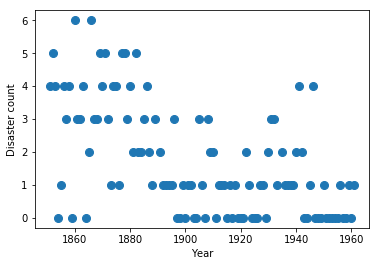

In [7]:
plt.plot(year, disaster_data, 'o', markersize=8);
plt.ylabel("Disaster count")
plt.xlabel("Year")

# $D_t \sim Poisson(rt)$  The number of disasters in year t
### $r_t$ = l,if t < s ; e,if t $\geq$ s   : The rate parameter of the Poisson distribution of disasters in year t
### s $\sim$ Unif($t_l$, $t_h$) : The year in which the rate parameter changes (the switchpoint)
### e $\sim$ exp(1) : The rate parameter before the switchpoint s
### l $\sim$ exp(1) : The rate parameter before the switchpoint s

### $t_l$, $t_h$: The lower and upper boundaries of year t.

In [10]:
from pymc3 import DiscreteUniform, Poisson 
import pymc3 as pm
 

In [14]:
with pm.Model() as disaster_model:
    switchpoint = DiscreteUniform('switchpoint', lower=year.min(),upper=year.max(), testval=1900)
    # Priors for pre- and post-switch rates number of disasters
    early_rate = pm.Exponential('early_rate', 1)
    late_rate = pm.Exponential('late_rate', 1)
    # Allocate appropriate Poisson rates to years before and after current
    rate = tt.switch(switchpoint >= year, early_rate, late_rate)
    disasters = Poisson('disasters', rate, observed=disaster_data)

In [26]:
with disaster_model:
    step1 = pm.NUTS([early_rate, late_rate])
    step2 = pm.Metropolis([switchpoint, disasters.missing_values[0]] )
    %time trace = pm.sample(20000, step=[step1, step2])

/home/nilavro/irleak/lib/python3.5/site-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [late_rate_log__, early_rate_log__]
>CompoundStep
>>Metropolis: [disasters_missing]
>>Metropolis: [switchpoint]
 81%|████████  | 8510/10500 [00:33<00:07, 255.07it/s]/home/nilavro/irleak/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
 84%|████████▎ | 8793/10500 [00:34<00:06, 258.03it/s]/home/nilavro/irleak/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/nilavro/irleak/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
100%|███████

CPU times: user 1.2 s, sys: 195 ms, total: 1.4 s
Wall time: 39.3 s


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fcdd4d0dd68>,
      dtype=object)

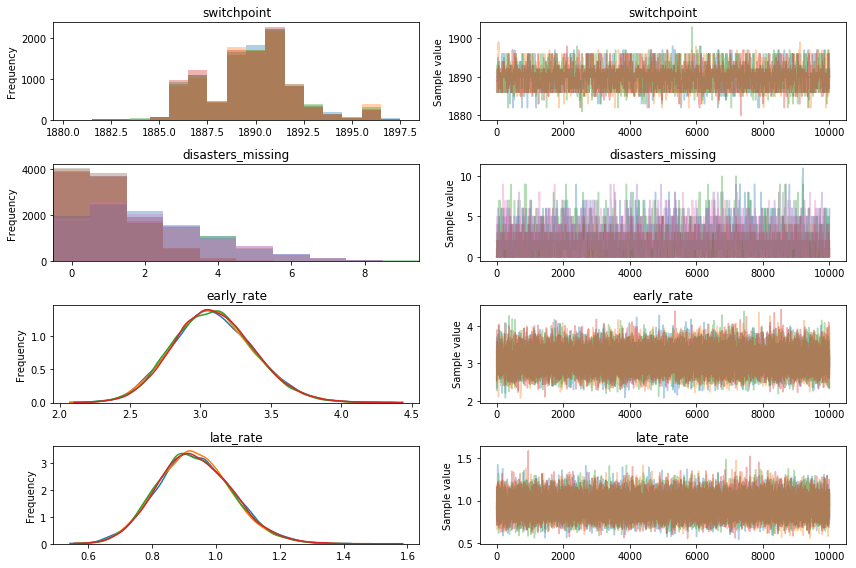

In [18]:
pm.traceplot(trace)

In [25]:
with disaster_model:
    %time approx = pm.fit(n=20000, obj_optimizer=pm.adagrad(learning_rate=1e-1))

Average Loss = inf: 100%|██████████| 20000/20000 [00:14<00:00, 1335.24it/s]   
Finished [100%]: Average Loss = 222.44


CPU times: user 15.6 s, sys: 1.25 s, total: 16.8 s
Wall time: 18.5 s


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fcde68f47f0>,
      dtype=object)

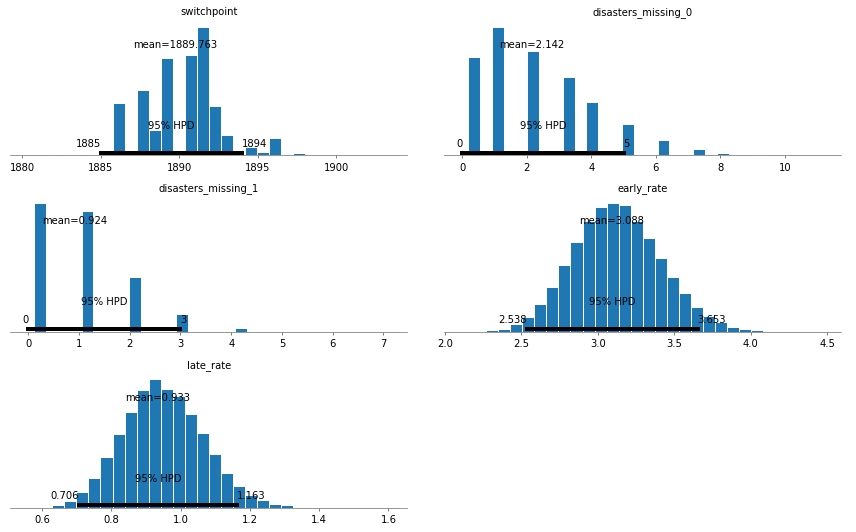

In [23]:
pm.plot_posterior(trace )